# Stephen King Novel NLP

## Imports

In [158]:
import pandas as pd
import numpy as np
from IPython import display
from pymongo import MongoClient
import os
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.util import ngrams
import operator
from gensim import corpora, models, similarities, matutils
from sklearn import datasets
import json
import spacy 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from afinn import Afinn
import random
import scipy
from scipy.signal import spectrogram
from importlib import reload
from scipy.fftpack import fft
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d


# gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import LdaModel

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


display.clear_output(wait=True)
from config import user_name,password,ip
from epub_conversion.utils import open_book

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 20, 10

## Stoplist

In [2]:
stoplist = stopwords.words('english')
stoplist += ['.', ',', '(', ')', "'", '"']
#stoplist = set(stoplist)

## Functions

### Manual Word Count

In [3]:
def clean_text(row):
    text = row['content'].lower()
    text = text.strip('\n')
    return text

### Manual Word Count

In [4]:
def book_word_count(book,n,stoplist=stoplist):
    text = clean_text(book)
    words = [''.join(words) for words in text.split()]
    title = book['title']
    counter = Counter()
    n = n
    words = [w for w in words if w not in stoplist]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)
    sorted_counter = sorted(counter.items(), key=operator.itemgetter(1),reverse=True)
    return title, sorted_counter

### Count Vectorizer Function

In [5]:
def book_cv(dtbooks,stoplist):
    cv = CountVectorizer(stop_words=stoplist,token_pattern="\\b[a-z][a-z]+\\b")
    print(type(dtbooks[0]))
    cv.fit(dtbooks)
    x = cv.transform(dtbooks)
    x_back = x.toarray()
    df = pd.DataFrame(x_back, columns=cv.get_feature_names())
    counts = cv.transform(dtbooks).transpose()
    print(counts.shape)
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    return df,corpus,id2word

### Display Topics

In [6]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Return Topics

In [83]:
def return_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        words = " ".join([feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(words)
        top_words = {'topic_idx':topic_idx,'words':words}
        topics.append(top_words)
    
    return topics

### Cleanup

In [8]:
def cleanup(token, lower = True):
    if lower:
       token = token.lower()
    return token.strip()

### Entity Detection

In [9]:
def ie_preprocess(document):
    document = ' '.join([i for i in document.split() if i not in stoplist])
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

In [10]:
def extract_names(document):
    names = []
    sentences = ie_preprocess(document)
    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                if chunk.label() == 'PERSON':
                    names.append(' '.join([c[0] for c in chunk]))
    return names

### Tokenize and Stem

In [11]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [12]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

### Sentiment

In [13]:
def a_sentiment(filename):
    with open (filename, "r") as myfile:
        text=myfile.read().replace('\n', ' ')
        blob = TextBlob(text)       
        tot = 0.0
        sent = []        
        afinn = Afinn()
        for sentence in blob.sentences:            
            senti = afinn.score(str(sentence))        
            sent.append(senti)   
        return sent

### Sentiment Plot

In [14]:
def sentiplot(filename, title):
    fig = plt.figure()
    sent= a_sentiment(filename)    
    plt.plot(sent,label=title)
    plt.ylabel("Cumulative Emotional Valence")
    plt.xlabel("Sentence #")    
    plt.legend()


### Plot Stories

In [167]:
def plot_story(title,df=sentDF,f=.1,d=0.0):
    bookDF = df.loc[df['title'] == title]
    sentiment = list(bookDF.sentiment)
    lowX = list(range(1,len(sentiment)+1))
    #print(len(sent),len(lowX))
    low_plot = lowess(sentiment,lowX,frac=.1,return_sorted=False,delta=d)
    f2 = interp1d(lowX, sentiment, kind='cubic')
    title = title
    fig = plt.figure()
    plt.plot(low_plot,label=title)
    plt.ylabel("Sentiment Score")
    plt.xlabel("Sentence #")    
    plt.legend()

## Data Processing

**Create a dictionary from all books**

In [18]:
# book_list = []
# book_dict = {}
# path = "/Users/xavier/dev/metis/fletcher/books/"
# for file in os.listdir(path):
#     if file.endswith(".txt"):
#         clean_name = file.replace(" - Stephen King.txt","")
#         book_dict[clean_name] = open(path+file, "r").read()
#         book_list.append(clean_name)

In [19]:
# # Insert the books into mongo db
# clean_list = []
# for k,v in book_dict.items():
#     try:
#         year = re.search("[Cc]opyright ©\s*.*_*(\d{4}).*Stephen King|[Cc]opyright ©\s.*Stephen King.*_*(\d{4})|[Cc]opyright ©\s*.*_*(\d{4}).*Richard Bachman|[Cc]opyright ©\s.*Richard Bachman.*_*(\d{4})",v).group(0) # get copyright year from book text
#         year = re.search("(\d{4})",year).group(0)
#     except:
#         year = ""
#     try:
#         isbn = re.search(".*ISBN+:*(\d*.*)",v)[1].split(" ")
#         isbn = max(isbn, key=len)
#     except:
#         isbn = ""
#     try:
#         start = v.find('******start_of_file******')+25
#         end = v.find('******end_of_file******')
#         text = v[start:end]
#     except:
#         text = ""
        
#     doc = {"title":k,"year":year,'isbn':isbn,"content":text}
#     clean_list.append(doc)
#     #print(doc['title'],doc['isbn'])
#     #print(doc['title'],doc['year'])
#     #db.books.insert_one(doc)

In [20]:
# len(clean_list)

In [21]:
# #pd.DataFrame(a, index=['i',])
# df = pd.DataFrame(clean_list)

In [22]:
# df.to_pickle('books.pkl')

### Import Pickle

In [23]:
df = pd.read_pickle('books.pkl')

In [24]:
df.columns.tolist()

['content', 'isbn', 'title', 'year']

In [25]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


In [26]:
document = df.iloc[28]['content']

In [27]:
# df['content'] = df.content.apply(lambda x: x.lower())
# df['content'] = df.content.apply(lambda x: x.strip("\n"))

In [28]:
# words = [''.join(words) for words in gs_text.split()]
# vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1))
# doc_vectors = vectorizer.fit_transform(documents)

### Character extraction test

In [29]:
characters = extract_names(document)

In [30]:
characters

['Penguin Book',
 'Stephen King',
 'Penguin Putnam',
 'Penguin Books',
 'Penguin Putnam',
 'Penguin Putnam',
 'STEPHEN',
 'Carrie',
 'Salem',
 'Christine Pet Sematary Cycle Werewolf',
 'Peter Straub',
 'Dolores Claiborne Insomnia Rose Madder',
 'Wizard Glass Bag Bones',
 'Tom Gordon Dreamcatcher Black House',
 'Peter Straub',
 'Skeleton Crew',
 'Atlantis Everything',
 'Eventual SCREENPLAYS Creepshow Cat',
 'Eye Silver Bullet Maximum Overdrive Pet Sematary Golden',
 'Century',
 'Who',
 'Merrys Pippins',
 'Max Yasgur',
 'Great Woodstock Music Festival',
 'Gandalfs',
 'Tolkien',
 'Stephen Donaldson',
 'Terry Brooks',
 'Tolkien',
 'Tolkien',
 'Tricky Dick Nixon',
 'Mr. Tolkien',
 'Look',
 'Stevie',
 'Nineteen',
 'Bob Seger',
 'Patrol Boy',
 'Bad Lieutenant',
 'Patrol Boy',
 'Mine',
 'Stephen',
 'God',
 'Tolkien',
 'Pall Malls',
 'Patrol Boy',
 'Maine',
 'Sergio Leone',
 'Bad',
 'Ugly',
 'Tolkien',
 'Leone',
 'Clint',
 'Lee Van Cleef',
 'Wizard Glass',
 'Leone',
 'Phoenix',
 'Seems',
 'Patr

In [31]:
characters = [s.split(" ") for s in characters]

In [32]:
flat_list = [item for sublist in characters for item in sublist]

In [33]:
flat_list

['Penguin',
 'Book',
 'Stephen',
 'King',
 'Penguin',
 'Putnam',
 'Penguin',
 'Books',
 'Penguin',
 'Putnam',
 'Penguin',
 'Putnam',
 'STEPHEN',
 'Carrie',
 'Salem',
 'Christine',
 'Pet',
 'Sematary',
 'Cycle',
 'Werewolf',
 'Peter',
 'Straub',
 'Dolores',
 'Claiborne',
 'Insomnia',
 'Rose',
 'Madder',
 'Wizard',
 'Glass',
 'Bag',
 'Bones',
 'Tom',
 'Gordon',
 'Dreamcatcher',
 'Black',
 'House',
 'Peter',
 'Straub',
 'Skeleton',
 'Crew',
 'Atlantis',
 'Everything',
 'Eventual',
 'SCREENPLAYS',
 'Creepshow',
 'Cat',
 'Eye',
 'Silver',
 'Bullet',
 'Maximum',
 'Overdrive',
 'Pet',
 'Sematary',
 'Golden',
 'Century',
 'Who',
 'Merrys',
 'Pippins',
 'Max',
 'Yasgur',
 'Great',
 'Woodstock',
 'Music',
 'Festival',
 'Gandalfs',
 'Tolkien',
 'Stephen',
 'Donaldson',
 'Terry',
 'Brooks',
 'Tolkien',
 'Tolkien',
 'Tricky',
 'Dick',
 'Nixon',
 'Mr.',
 'Tolkien',
 'Look',
 'Stevie',
 'Nineteen',
 'Bob',
 'Seger',
 'Patrol',
 'Boy',
 'Bad',
 'Lieutenant',
 'Patrol',
 'Boy',
 'Mine',
 'Stephen',
 'G

In [34]:
characters = set(flat_list)
characters = list(characters)

In [35]:
stoplist = list(stoplist)
stoplist.extend(characters)
stoplist = set(stoplist)

In [36]:
print(stoplist)

{'Blue', 'Steven', 'Eldred', 'Antichrist.', 'Gran', 'Heaven', 'DeCurry', 'Seven', 'Network', 'Handcar', 'Carrie', 'Marten', 'Overdrive', 'before', 'Yasgur', 'Drop', 'Crew', 'is', 'Old', 'more', 'up', 'Thomas', 'Numbed', 'Wormword', 'very', 'then', 'Lieutenant', 'Volcanoes', 'mustn', 'Town', 'Suppose', 'Walk', 'Ageless', 'each', 'Good', 'Ain', 'Clean', 'for', 'did', 'Silva', 'than', 'after', 'Treason', 'Flies', 'Someone', 'Everything', 'had', 'of', 'o', 'High', 'Mistuh', 'been', 'shan', 'Has', 'Dinner', 'Seger', 'be', 't', 'Tet', 'Room', 'Volume', 'Serpents', 'Bones', 'Broken', 'didn', 'Verriss', 'Charles', 'Michigan', 'Yar', 'Science', 'Factor', 'having', '"', 'Pittston', 'Make', 'Paul', 'John', 'Sylvia', 'if', 'Gabrielle', 'Wipe', "'", 'Daddy', 'Damascus', 'other', 'Jonas', 'Jezebel', 'Boy', 'Hello', 'Christine', 'Don', 'Round', 'being', 'you', 've', 'Will', 'Delgado', 'Coffin', 'Cort', 'Na', 'these', 'Tower', 'Fresh', 's', 'his', 'Oracle', 'hers', 'through', 'Empires', 'Who', 'Allgoo

### Word Tokenize

In [37]:
# df['content'] = df.content.apply(lambda x: word_tokenize(x))

In [38]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


### Omit Stop Words

In [39]:
# df['content'] = df.content.apply(lambda x: [word for word in x if word not in stoplist])

In [40]:
# df.head()

### Convert tokens back to a long string

In [41]:
# df['content'] = df.content.apply(lambda x: " ".join(x))

In [42]:
# df.head()

### Sentence Tokenize

In [43]:
df['content'] = df.content.apply(lambda x: sent_tokenize(x))

In [44]:
df.head()

,content,isbn,title,year
0,[d by “Duel”\n\nJoe Hill and Stephen King\n\n\...,9780062215956,Throttle,2009
1,[TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nInt...,978-0-385-52884-9,Night Shift,1976
2,"[ this Scribner eBook., * * *\n\n\n\nSign up f...",0-7432-0467-0,Riding the Bullet,2000
3,[ Page\n\nCopyright Page\n\nDedication\n\n\n\n...,978-1-101-13813-7,Roadwork,1981
4,[dication\n\nIntroduction\n\nAuthor’s Note\n\n...,978-0-385-52822-1,Salem's Lot,1975


### Paragraph Tokenize

### Stem Words

In [45]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [46]:
df['content'] = df.content.apply(lambda x: [stemmer.stem(word) for word in x])

In [47]:
df.head()

,content,isbn,title,year
0,[d by “duel”\n\njoe hill and stephen king\n\n\...,9780062215956,Throttle,2009
1,[ts\n\n\n\ncover page\n\ntitle page\n\n\n\nint...,978-0-385-52884-9,Night Shift,1976
2,"[ this scribner ebook., * * *\n\n\n\nsign up f...",0-7432-0467-0,Riding the Bullet,2000
3,[ page\n\ncopyright page\n\ndedication\n\n\n\n...,978-1-101-13813-7,Roadwork,1981
4,[dication\n\nintroduction\n\nauthor's note\n\n...,978-0-385-52822-1,Salem's Lot,1975


In [48]:
titles = df.title

In [49]:
books = df.content

In [50]:
books[4][:500]

["dication\n\nintroduction\n\nauthor's note\n\n\n\n'salem's lot\n\n\n\nprologue\n\npart one\n\nthe marsten house\n\nchapter one ben (i)\n\nchapter two susan (i)\n\nchapter three the lot (i)\n\nchapter four danny glick and others\n\nchapter five ben (ii)\n\nchapter six the lot (ii)\n\nchapter seven matt\n\npart two\n\nthe emperor of ice cream\n\nchapter eight ben (iii)\n\nchapter nine susan (ii)\n\nchapter ten the lot (iii)\n\nchapter eleven ben (iv)\n\nchapter twelve mark\n\nchapter thirteen father callahan\n\npart three\n\nthe deserted village\n\nchapter fourteen the lot (iv)\n\nchapter fifteen ben and mark\n\nepilogue\n\n\n\none for the road\n\njerusalem's lot\n\ndeleted scenes\n\n\n\nafterword\n\ncopyright\n\n\n\n\n\nfor naomi rachel king\n\n“…promises to keep.”\n\n\n\n\n\nintroduction to 'salem's lot\n\nby stephen king\n\nmy father-in-law is now retired, but when he was working for maine's department of human services, he had a very cool sign in his office.",
 'it said once i had n

### Lower Stop List

In [51]:
stoplist = [x.lower() for x in stoplist]

### Convert sentences to Rows

In [52]:
s = df.apply(lambda x: pd.Series(x['content']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'content'
sentDF = df.drop('content', axis=1).join(s)

In [53]:
sentDF.head()

,isbn,title,year,content
0,9780062215956,Throttle,2009,d by “duel”\n\njoe hill and stephen king\n\n\n...
0,9780062215956,Throttle,2009,"finally, in the early afternoon, they turned i..."
0,9780062215956,Throttle,2009,the overlapping thunder of their engines shook...
0,9780062215956,Throttle,2009,they drew up together among parked long-haul t...
0,9780062215956,Throttle,2009,"race adamson had led them the whole way, his h..."


In [54]:
cujoDF = sentDF.loc[sentDF['title'] == 'Cujo']

In [55]:
cujoDF

,isbn,title,year,content
60,978-1-101-13806-9,Cujo,1981,page\n\ncopyright page\n\ndedication\n\n\n\n\...
60,978-1-101-13806-9,Cujo,1981,.
60,978-1-101-13806-9,Cujo,1981,.
60,978-1-101-13806-9,Cujo,1981,"cujo\n\nit happens innocently enough, but does..."
60,978-1-101-13806-9,Cujo,1981,"a big, friendly dog chases a rabbit into a hid..."
60,978-1-101-13806-9,Cujo,1981,a terrified four-year-old boy sees his bedroom...
60,978-1-101-13806-9,Cujo,1981,the little maine town of castle rock is about ...
60,978-1-101-13806-9,Cujo,1981,“hits the jugular.”\n\n—new york times\n\n\n\n...
60,978-1-101-13806-9,Cujo,1981,"250 camberwell road, camberwell."
60,978-1-101-13806-9,Cujo,1981,victoria 3124.


In [56]:
books = sentDF.content

### Processing Sentences

In [57]:
# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in books:
#     allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
#     totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)

In [58]:
# totalvocab_stemmed

In [59]:
titles = sentDF.title
#titles

In [60]:
len(books)

748650

## Sentiment Analysis

In [61]:
dfRaw = pd.read_pickle('books.pkl')

In [62]:
#Cujo Test
cujo = dfRaw.loc[dfRaw['title'] == 'Cujo']

In [63]:
cujo.to_pickle('cujodf.pkl')

In [64]:
cujo.content

60     Page\n\nCopyright Page\n\nDedication\n\n\n\n\...
Name: content, dtype: object

In [65]:
TextBlob(str(cujo.content)).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [66]:
cujoDF['sentiment'] = cujoDF.content.apply(lambda x: TextBlob(x).sentiment[0])

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


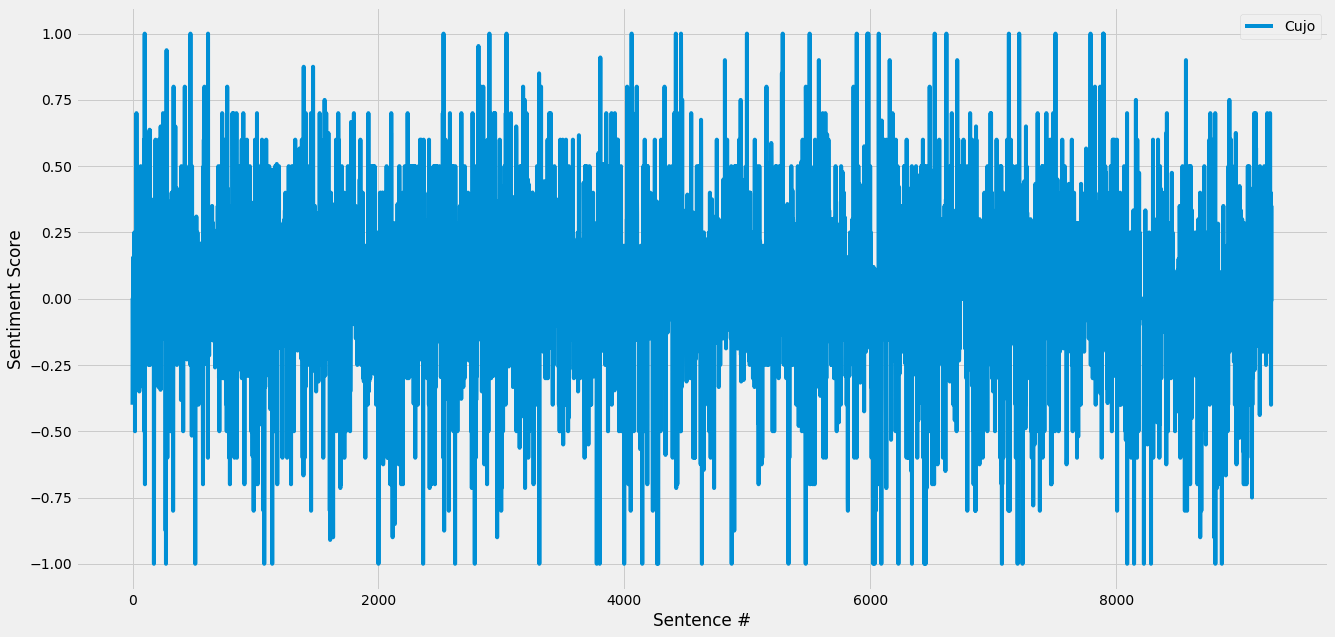

In [67]:
sent = list(cujoDF.sentiment)
title = 'Cujo'
fig = plt.figure()
plt.plot(sent,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence #")    
plt.legend()

In [68]:
# sentiplot('books/Girl Who Loved Tom Gordon_ A Novel, The - Stephen King.txt','Girl who loved tom gordon')

In [69]:
cumsum_vec = np.cumsum(np.insert(sent, 0, 0)) 
ma_vec = (cumsum_vec[300:] - cumsum_vec[:-300]) / 300

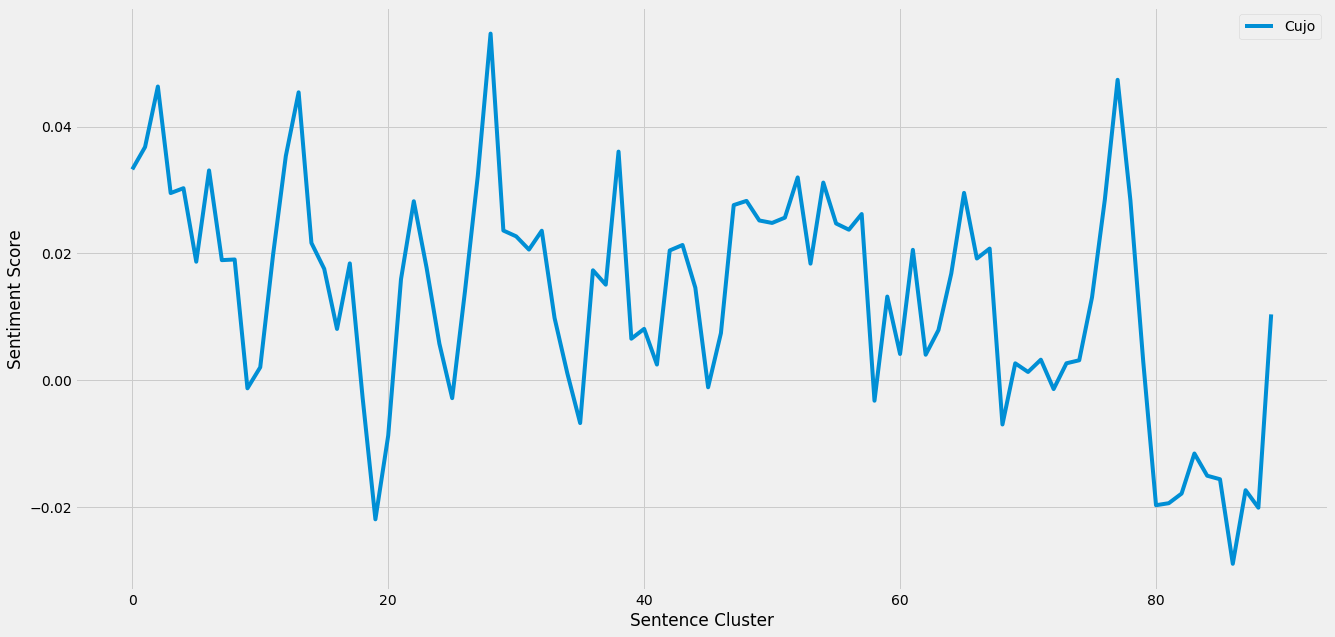

In [70]:
title = 'Cujo'
fig = plt.figure()
plt.plot(ma_vec[::100],label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence Cluster")    
plt.legend()

In [71]:
sent

[-0.40000000000000002,
 0.0,
 0.0,
 0.0,
 -0.19791666666666666,
 0.0,
 0.15625,
 0.041841491841491822,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13636363636363635,
 0.13636363636363635,
 0.0,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.5,
 0.0,
 0.0,
 0.0,
 -0.066666666666666666,
 0.0,
 -0.3125,
 0.0,
 0.20000000000000001,
 0.0,
 -0.066666666666666666,
 0.081250000000000003,
 0.69999999999999996,
 0.5,
 0.11666666666666665,
 0.0,
 0.0,
 0.0,
 -0.04791666666666667,
 0.072222222222222202,
 -0.037500000000000006,
 0.051666666666666666,
 0.049999999999999989,
 0.39999999999999997,
 0.058333333333333341,
 0.0,
 0.39000000000000001,
 0.061111111111111109,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.02777777777777779,
 -0.34999999999999998,
 -0.09375,
 -0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.24666666666666667,
 0.0,
 0.0,
 -0.20000000000000001,
 0.0,
 0.0,
 -0.20000000000000001,
 0.0,
 0.0,
 0.0625,
 0.077777777777777793,
 0.0,
 0.0,
 0.013333333333333353,
 -0.33124999999999999,
 0.3499999

In [72]:
sent_group = []
for x in range(0, len(sent), 300):
     sent_group.append( sum(sent[x:x+300])/300 )

In [73]:
len(sent_group)

31

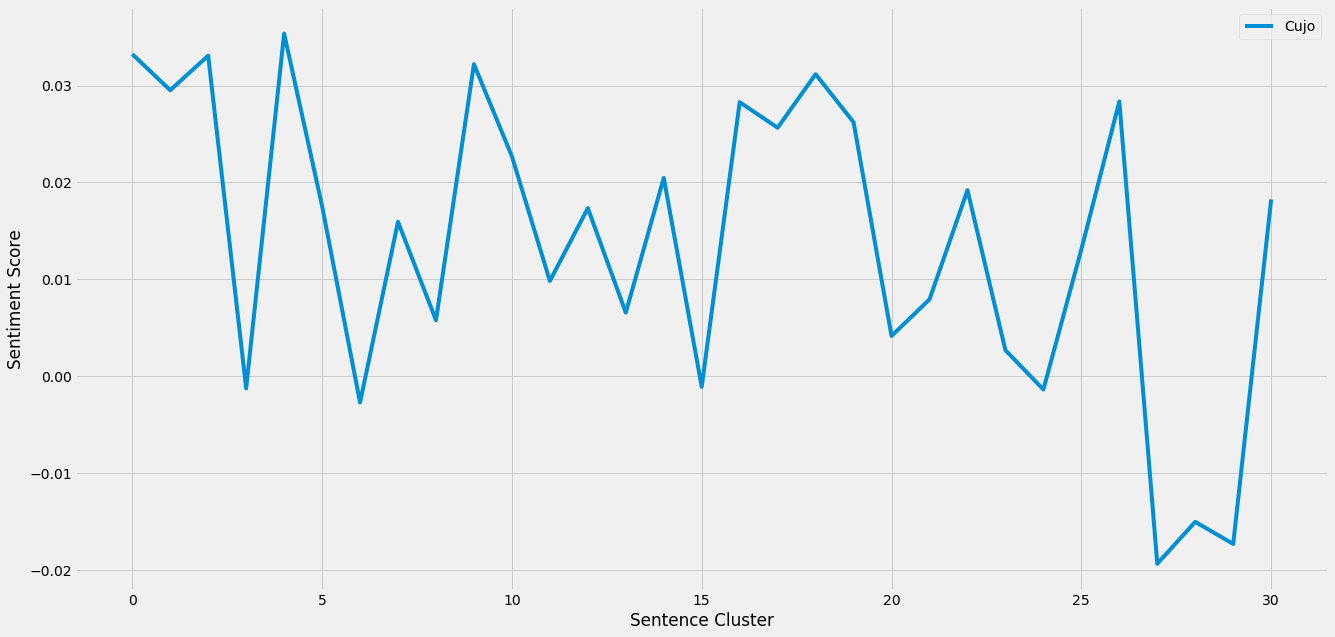

In [74]:
title = 'Cujo'
fig = plt.figure()
plt.plot(sent_group,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence Cluster")    
plt.legend()

In [75]:
sentDF['sentiment'] = sentDF.content.apply(lambda x: TextBlob(x).sentiment[0])

In [76]:
sentDF.to_pickle('sentiment.pkl')

### Smoothing

In [236]:
sorted(unique_titles)

['11_22_63',
 'Bag of Bones_ A Novel',
 'Big Driver',
 'Blaze_ A Novel',
 'Blockade Billy',
 'Carrie',
 'Cell',
 'Colorado Kid, The',
 'Cujo',
 'Dark Half, The',
 'Dark Tower, The',
 'Dead Zone, The',
 'Desperation',
 'Different Seasons',
 'Doctor Sleep_ A Novel',
 'Dolores Claiborne',
 'Drawing of the Three, The',
 'Dreamcatcher_ A Novel',
 "Everything's Eventual_ 14 Dark Tales",
 'Eyes of the Dragon, The',
 'Face in the Crowd, A',
 'Finders Keepers',
 'Firestarter',
 'Four Past Midnight',
 'From a Buick 8_ A Novel',
 'Full Dark, No Stars',
 "Gerald's Game",
 'Girl Who Loved Tom Gordon_ A Novel, The',
 'Good Marriage, A',
 'Green Mile_ The Complete Serial Novel, The',
 'Gunslinger, The',
 'Hearts in Atlantis',
 'In the Tall Grass',
 'Insomnia',
 'It',
 'Joyland',
 'Just After Sunset_ Stories',
 "Lisey's Story_ A Novel",
 'Long Walk, The',
 'Mile 81',
 'Misery',
 'Mist, The',
 'Mr. Mercedes',
 'Needful Things_ The Last Castle Rock Story',
 'Night Shift',
 'Nightmares & Dreamscapes',
 '

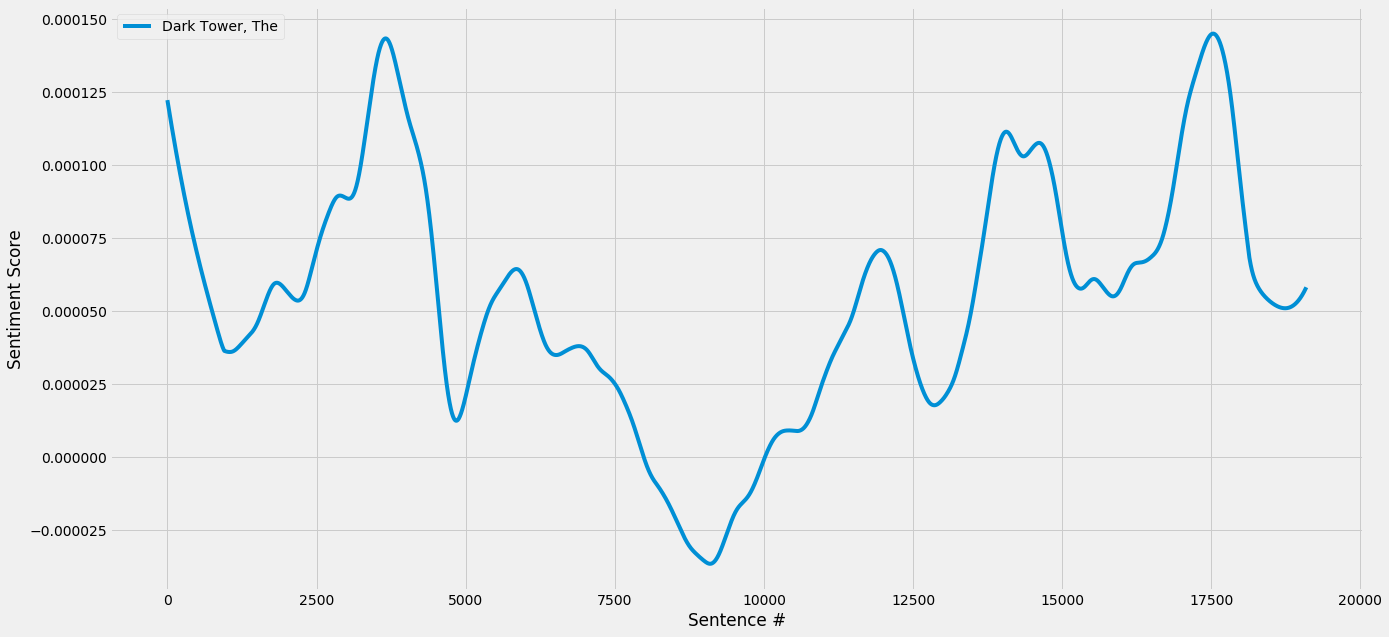

In [168]:
plot_story('Dark Tower, The',sentDF)

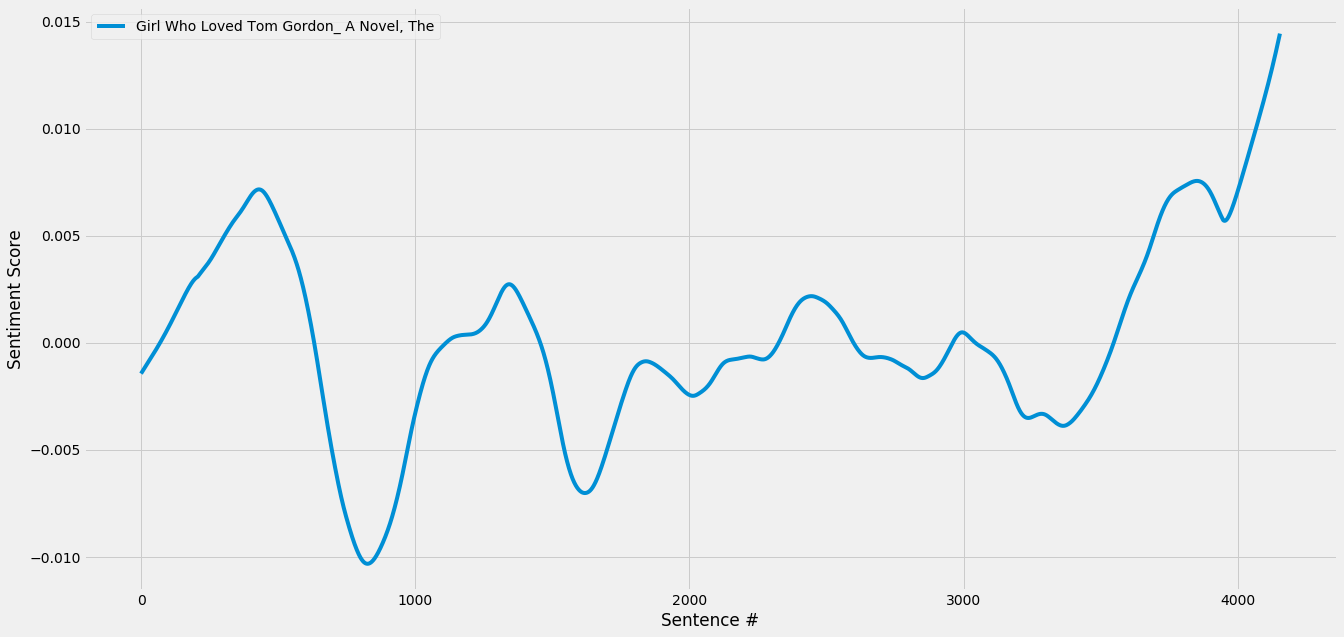

In [238]:
plot_story('Girl Who Loved Tom Gordon_ A Novel, The',sentDF)

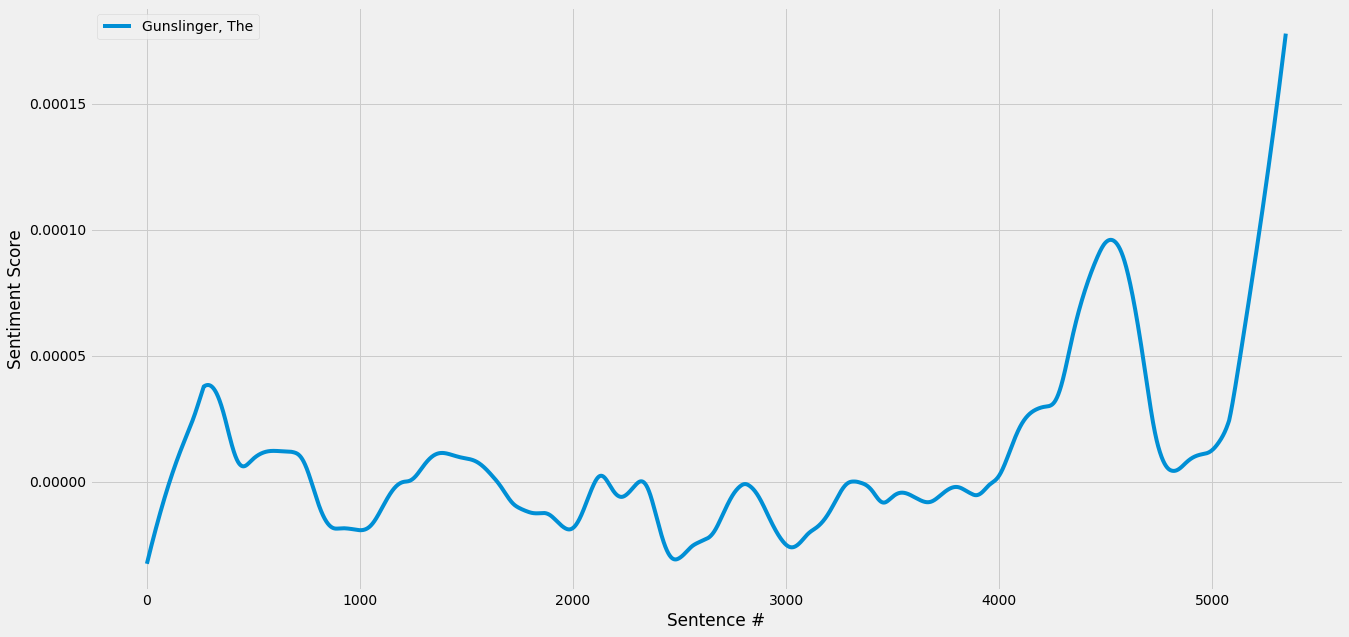

In [261]:
plot_story('Gunslinger, The')

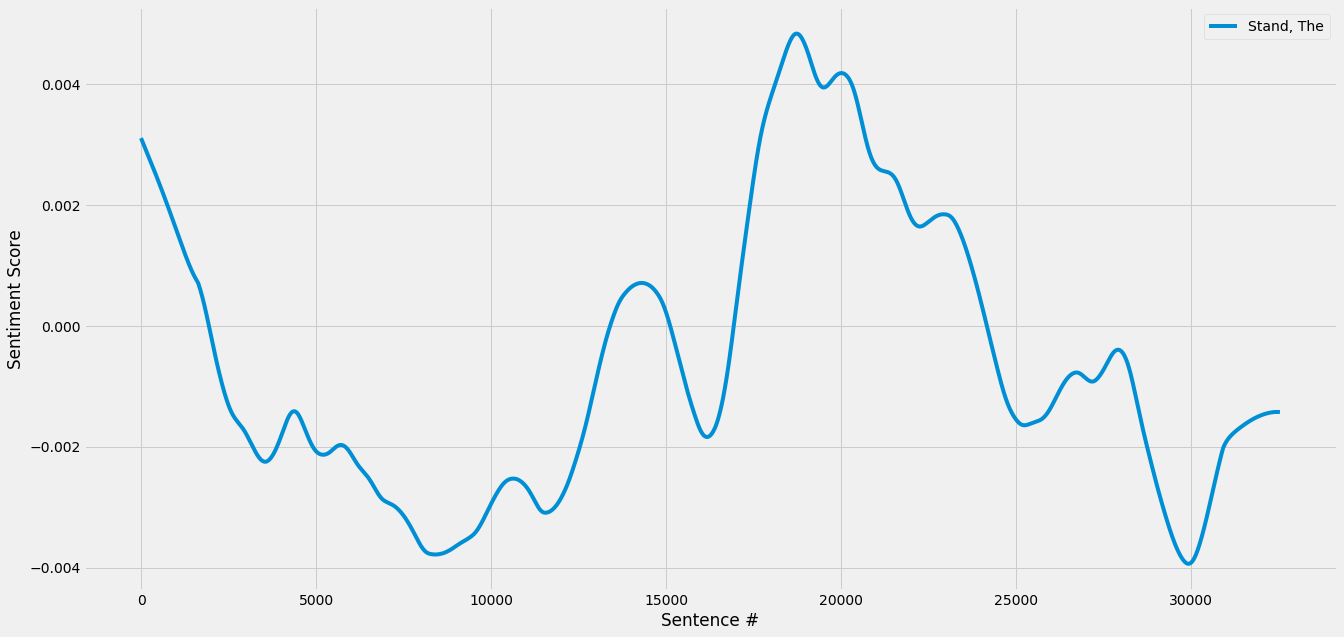

In [246]:
plot_story('Stand, The')

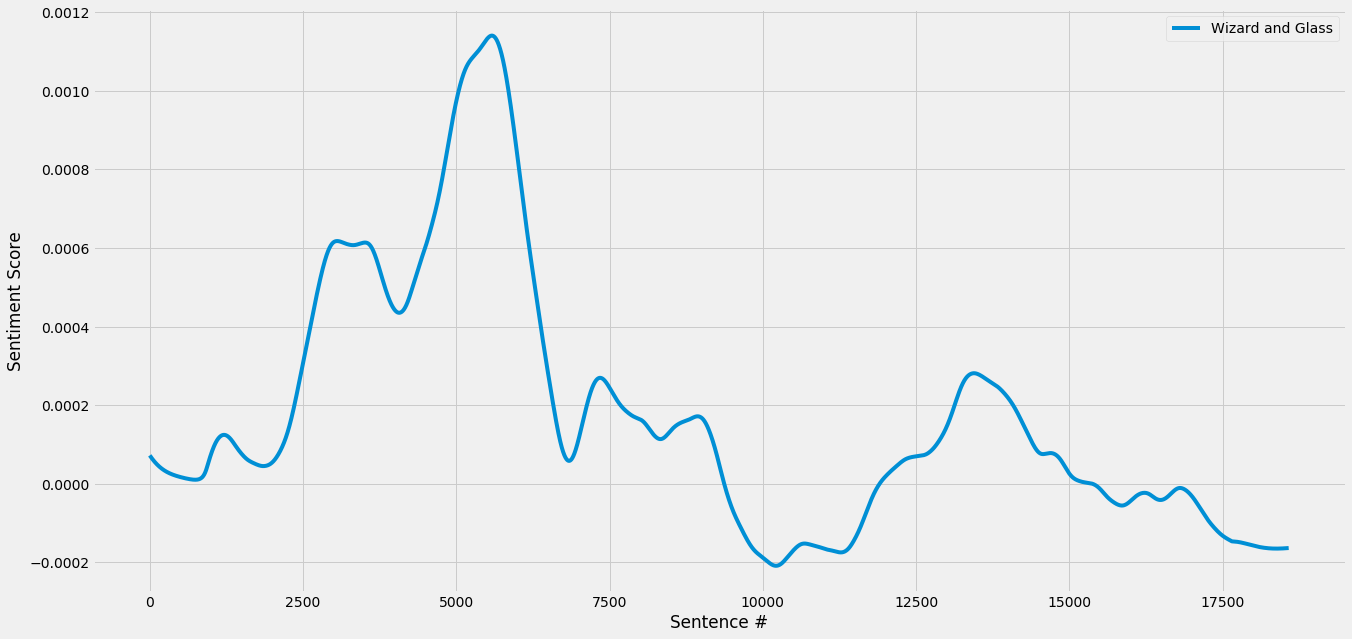

In [247]:
plot_story('Wizard and Glass')

In [167]:
lowX = list(range(1,len(sent)+1))
print(len(sent),len(lowX))
low_plot = lowess(sent,lowX,frac=.1,return_sorted=False)

9262 9262


In [168]:
low_plot

array([  3.68503313e-08,   3.66196209e-08,   3.63887654e-08, ...,
        -2.58071612e-06,  -2.59462443e-06,  -2.60852202e-06])

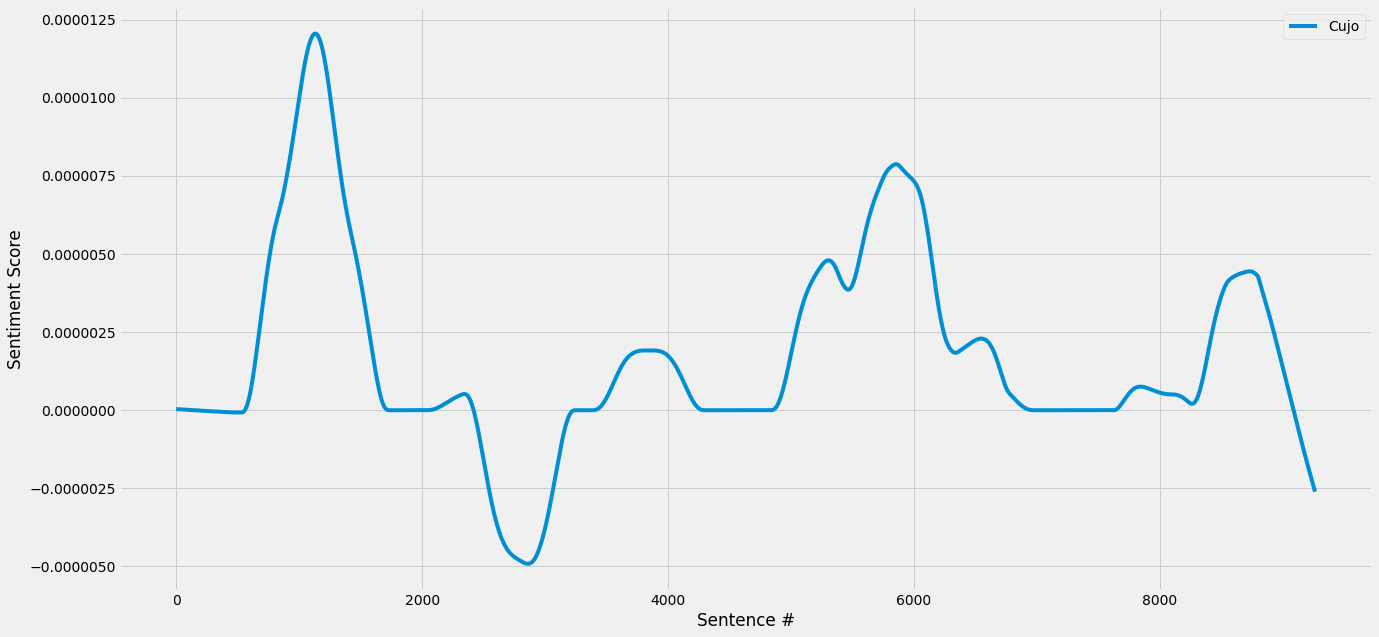

In [169]:
title = 'Cujo'
fig = plt.figure()
plt.plot(low_plot,label=title)
plt.ylabel("Sentiment Score")
plt.xlabel("Sentence #")    
plt.legend()

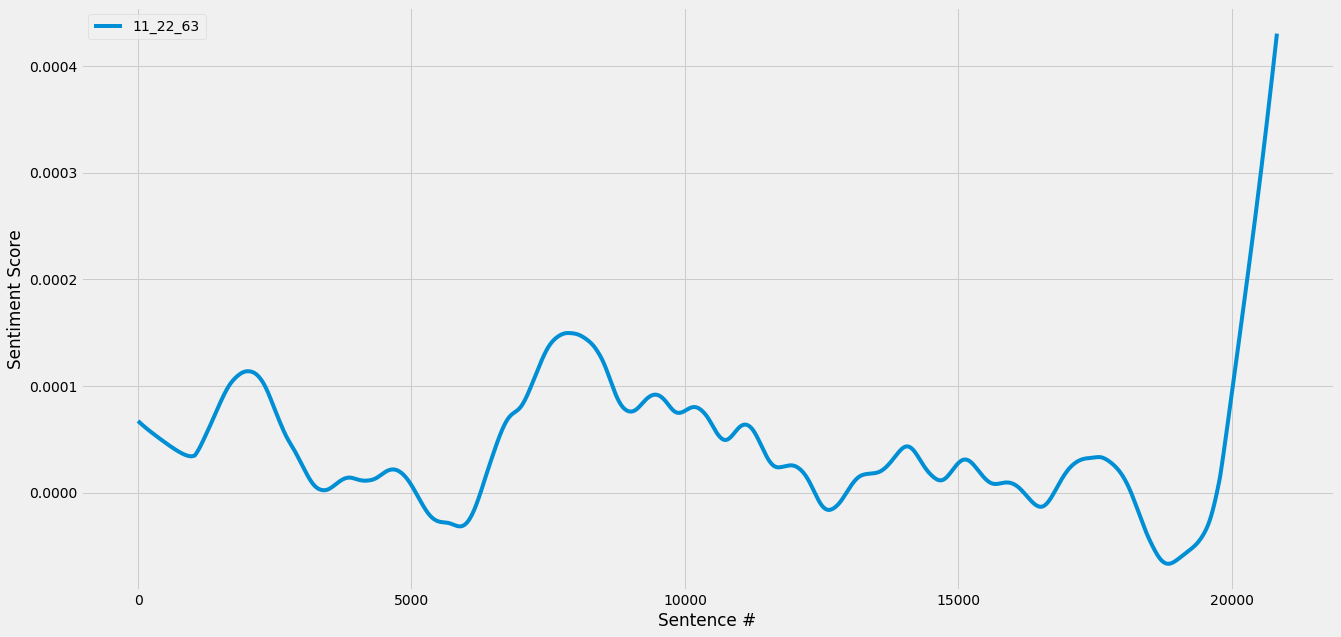

In [170]:
plot_story('11_22_63')

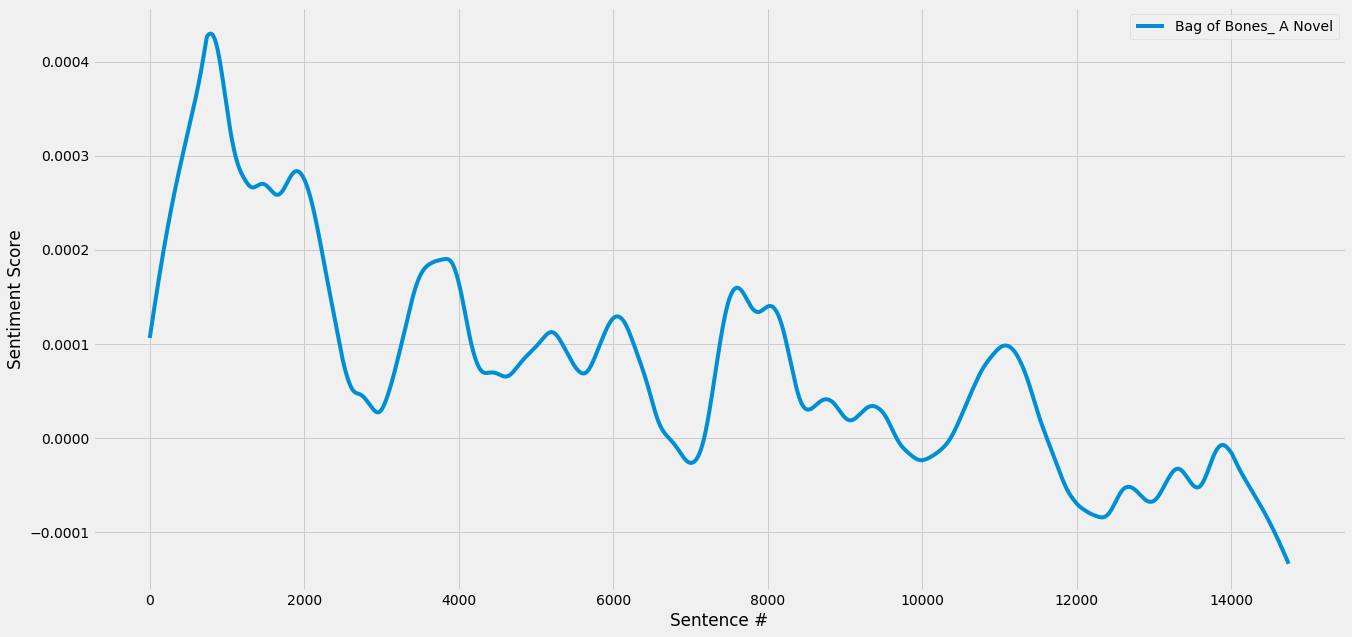

In [250]:
plot_story('Bag of Bones_ A Novel')

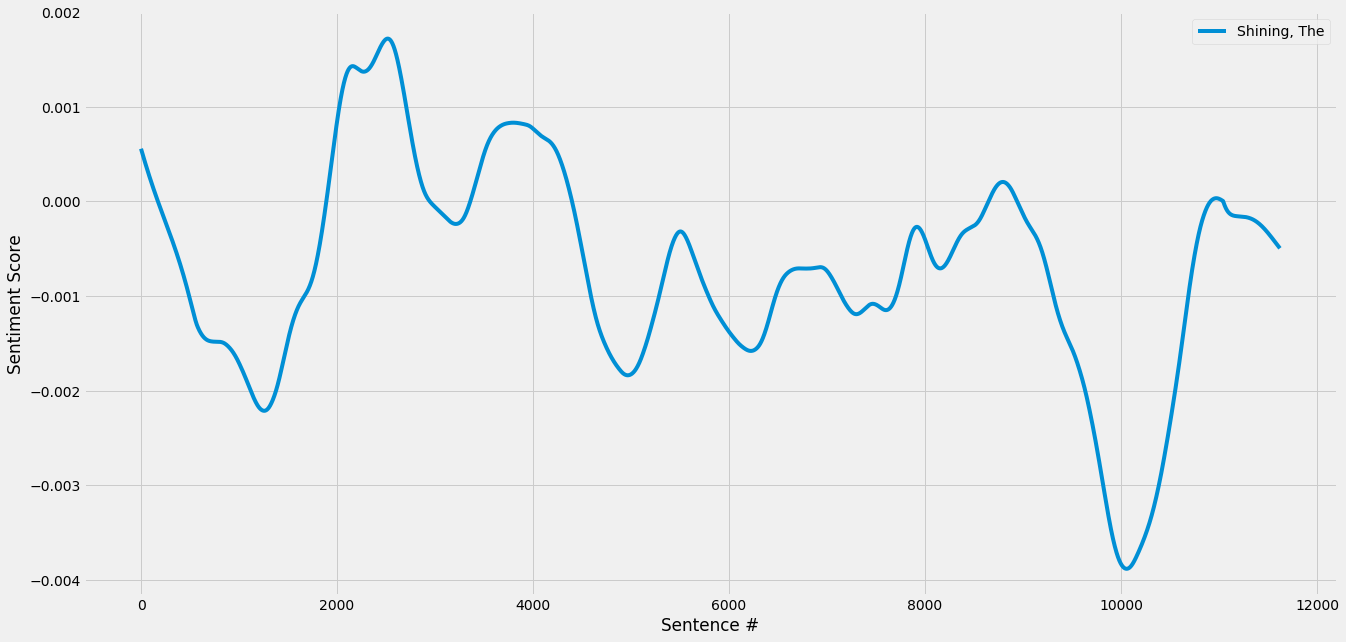

In [171]:
plot_story('Shining, The')

### Novel Sentiment Average

In [148]:
sentGroup = sentDF.groupby('title').sentiment.mean().reset_index()
sentGroup.sort_values('sentiment',ascending=False,inplace=True)

In [149]:
sentGroup

,title,sentiment
7,"Colorado Kid, The",0.057708
35,Joyland,0.057485
14,Doctor Sleep_ A Novel,0.048100
48,Revival,0.046053
2,Big Driver,0.042320
0,11_22_63,0.042077
65,"Wind Through the Keyhole_ A Dark Tower Novel, The",0.041659
67,Wolves of the Calla,0.041175
21,Finders Keepers,0.041160
51,Rose Madder,0.041020


## Test Method

In [69]:
title_list = list(dfRaw.title)

In [70]:
book_list = list(dfRaw.content)

In [71]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in book_list:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [72]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 10445058 items in vocab_frame


### TFID Test

In [75]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.2, stop_words=stoplist,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(book_list) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(68, 28201)


In [76]:
tf_terms = tfidf_vectorizer.get_feature_names()

### NMF Test

In [272]:
nmf_test = NMF(n_components=20, init='random')
fit_test = nmf_test.fit_transform(tfidf_matrix)

NameError: name 'tfidf_matrix' is not defined

In [271]:
display_topics(nmf_test,tf_terms,10)

NameError: name 'nmf_test' is not defined

### Vizualize NMF

In [168]:
x = []
y = []
order_model = nmf.components_.argsort()[:, ::-1]
components = nmf.components_

for i in range(len(components)):
    tempx = []
    tempy = []
    for index in order_model[i, :20]:
        tempx.append(str(vocab_frame.loc[tf_terms[index].split(' ')]
                     .values.tolist()[0][0]))
        tempy.append(components[i][index])
    x.append(tempx)
    y.append(tempy)

IndexError: list index out of range

In [ ]:
sns.set(font_scale=1)
f, axarr = plt.subplots(10, figsize=(8,25), sharex=False)
for i in range(10):
    title = "KMeans Topic %d" % i
    figsize(6,1.25)
    sns.set(style="dark")
#     sns.set_color_codes("muted") x[i]
    sns.barplot(x=x_k[i], y=y_k[i], color='black', ax=axarr[i])
    axarr[i].set_title(title)
    axarr[i].set_ylim([0,0.6])
#     plt.xticks(rotation=90)
    sns.despine(left=True, bottom=True)
for ax in f.axes:
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout(h_pad=3)

### Clustering Test

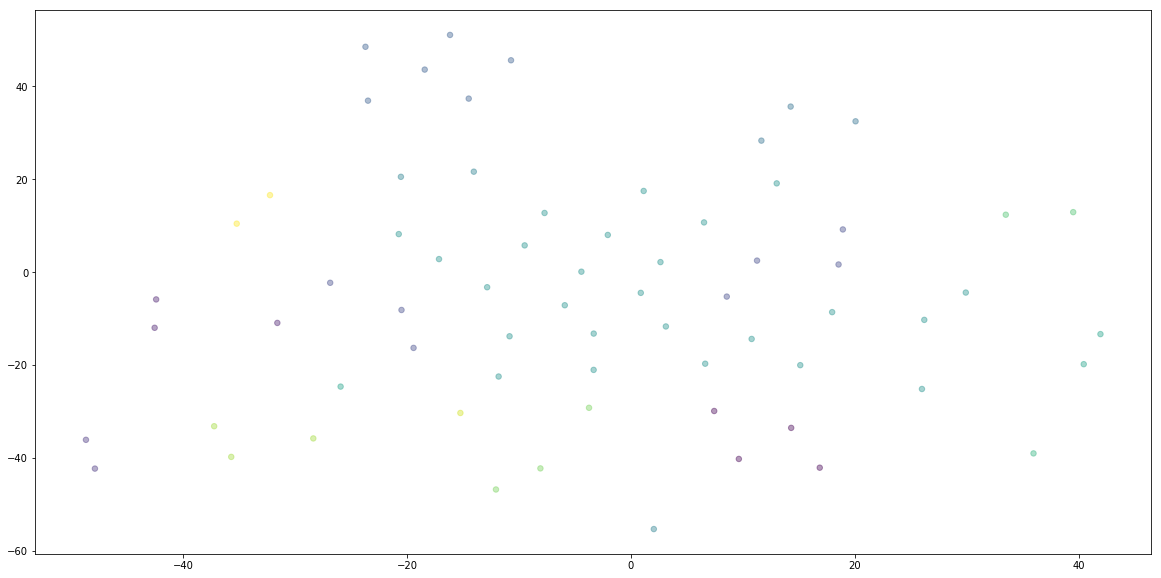

In [97]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(fit_test) 

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(fit_test)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [169]:
num_clusters = 10

km = KMeans(n_clusters=8)

km.fit(nmf_test)

clusters = km.labels_.tolist()

In [170]:
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [172]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

In [173]:
frame.cluster.value_counts()

0    43
1    16
4     6
2     2
3     1
Name: cluster, dtype: int64

### Spectral Clustering

In [157]:
from sklearn.cluster import spectral_clustering

In [159]:
sc = spectral_clustering(n_clusters=8,affinity='cosine')
sc.fit(tfidf_matrix)
sclusters = sc.labels.tolist()

AttributeError: 'str' object has no attribute 'ndim'

## Model Fits

### Count Vectorizer

In [64]:
cv = CountVectorizer(stop_words=stoplist,max_df=.002,token_pattern="\\b[a-z][a-z]+\\b")
x = cv.fit_transform(books)
cv_feature_names = cv.get_feature_names()
#x = cv.transform(books)

In [65]:
x.shape

(748650, 72769)

In [59]:
# x_back = x.toarray()

In [60]:
# bookDF = pd.DataFrame(x_back, columns=cv.get_feature_names())

In [61]:
# bookDF.head()

### TFIDF Vectorizer

In [128]:
tf = TfidfVectorizer(stop_words=stoplist,use_idf=True,max_df=.0018,token_pattern="\\b[a-z][a-z]+\\b")
x2 = tf.fit_transform(books)
tf_feature_names = tf.get_feature_names()

In [129]:
x2.shape

(748650, 72700)

### Cosine Similarity

In [ ]:
dist = 1 - cosine_similarity(x2)

### NMF

#### With Count Vectorizer

In [80]:
# nmf = NMF(n_components=20, init='random')
# fit = nmf.fit_transform(x)

In [81]:
# display_topics(nmf,cv_feature_names,10)

#### With TFIDF

In [130]:
nmf2 = NMF(n_components=20, init='random')
nmf_fit = nmf2.fit_transform(x2)

In [131]:
# no_top_words = 5
# no_top_documents = 2

In [132]:
display_topics(nmf2,tf_feature_names,10)

Topic 0:
shouted beverly steve ear grabbed todd surprise al rusty furiously
Topic 1:
wondered briefly mad possible richards idly noticed sleeping slept sam
Topic 2:
christ sake dear holy almighty muttered steve wish sweet hurry
Topic 3:
garraty mcvries stebbins baker olson ray shrugged warning grinned stared
Topic 4:
problem drinking solve serious steve simple solved replied solving mental
Topic 5:
changed minute bobbi wonder worry safe closer sit blaze understood
Topic 6:
lie asleep awake upstairs agreed promise makes listening lied catch
Topic 7:
glad safe damned rid sir bastard mort sight questions abra
Topic 8:
thanks welcome sir lloyd ride calling harold sam rosie asking
Topic 9:
larry callahan harold shrugged pere underwood nadine lucy glen cross
Topic 10:
crying harder beautiful rachel helen makes gulls duddits loudly leaned
Topic 11:
sick anymore stomach worry makes mad gets dying doctor hardly
Topic 12:
thad stark liz beaumont rawlie write pangborn wendy grinned muttered
Topic

In [133]:
topics = return_topics(nmf2,tf_feature_names,10)

Topic 0:
shouted beverly steve ear grabbed todd surprise al rusty furiously
Topic 1:
wondered briefly mad possible richards idly noticed sleeping slept sam
Topic 2:
christ sake dear holy almighty muttered steve wish sweet hurry
Topic 3:
garraty mcvries stebbins baker olson ray shrugged warning grinned stared
Topic 4:
problem drinking solve serious steve simple solved replied solving mental
Topic 5:
changed minute bobbi wonder worry safe closer sit blaze understood
Topic 6:
lie asleep awake upstairs agreed promise makes listening lied catch
Topic 7:
glad safe damned rid sir bastard mort sight questions abra
Topic 8:
thanks welcome sir lloyd ride calling harold sam rosie asking
Topic 9:
larry callahan harold shrugged pere underwood nadine lucy glen cross
Topic 10:
crying harder beautiful rachel helen makes gulls duddits loudly leaned
Topic 11:
sick anymore stomach worry makes mad gets dying doctor hardly
Topic 12:
thad stark liz beaumont rawlie write pangborn wendy grinned muttered
Topic

In [134]:
topicsDF = pd.DataFrame(topics)

In [135]:
topicsDF.head()

,topic_idx,words
0,0,shouted beverly steve ear grabbed todd surpris...
1,1,wondered briefly mad possible richards idly no...
2,2,christ sake dear holy almighty muttered steve ...
3,3,garraty mcvries stebbins baker olson ray shrug...
4,4,problem drinking solve serious steve simple so...


## Rejoin to Original DF

In [136]:
sentDF.columns

Index(['isbn', 'title', 'year', 'content', 'sentiment'], dtype='object')

In [137]:
np.mean(nmf_fit[sentDF['title'] == 'Cujo'], axis=0)

array([  3.11589106e-04,   9.96571597e-04,   7.34686586e-04,
         1.29718423e-04,   6.52457483e-04,   5.31562947e-03,
         4.87033316e-04,   2.68792359e-04,   2.41351706e-04,
         1.17281865e-04,   3.02984887e-04,   5.26766956e-04,
         8.28189152e-05,   2.91977613e-04,   1.35958746e-04,
         3.34096620e-04,   3.17080154e-04,   3.22023438e-04,
         9.21553649e-05,   3.24088187e-04])

In [138]:
unique_titles = list(set(titles))

In [139]:
topic_list = []
for title in unique_titles:
    topic_mean = np.mean(nmf_fit[sentDF['title'] == title], axis=0)
    #print(max(topic_mean))
    itemindex = np.where(topic_mean==max(topic_mean))
    #itemindex = topic_mean.argsort()[-3:][::-1]
    #print (int(itemindex[0]))
    topic_title = {"title":title,"topic_category":int(itemindex[0])}
    topic_list.append(topic_title)
    

In [140]:
topics_df = pd.DataFrame(topic_list)

In [141]:
topics_df.head(30)

,title,topic_category
0,Big Driver,5
1,"Gunslinger, The",5
2,"Tommyknockers, The",5
3,"Dark Half, The",12
4,Finders Keepers,5
5,From a Buick 8_ A Novel,5
6,"Eyes of the Dragon, The",5
7,In the Tall Grass,0
8,"Regulators, The",5
9,"Full Dark, No Stars",5


In [142]:
topicGroup = topics_df.groupby('topic_category').title.count().reset_index()
topicGroup.sort_values('title',ascending=False, inplace=True)

In [143]:
topicGroup

,topic_category,title
2,5,64
0,0,1
1,3,1
3,12,1
4,14,1


In [104]:
#joblib.dump(nmf2, 'nmf_tdidf.pkl')

['nmf_tdidf.pkl']

In [ ]:
#nmf_pickle = joblib.load('nmf_tdidf.pkl')

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(nmf_fit) 

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(nmf_fit)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, alpha=0.4, c=kmeans.labels_, marker='o', s=30);

In [ ]:
clusters = kmeans.clusters.tolist()

## Clustering

In [ ]:
# lda2.print_topics()

In [ ]:
# print(stoplist)

### K-Means

In [181]:
km2 = KMeans(n_clusters=8,init='k-means++')

km2.fit(x2)

clusters = km2.labels_.tolist()

In [182]:
clusters = km2.labels_.tolist()

In [183]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

ValueError: Shape of passed values is (2, 68), indices imply (2, 748650)

In [ ]:
frame.cluster.value_counts()

In [185]:
km3 = KMeans(n_clusters=8)

km3.fit(fit2)

clusters = km3.labels_.tolist()

In [186]:
clusters = km3.labels_.tolist()

In [187]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

In [188]:
frame.cluster.value_counts()

1    45
7     7
6     4
5     4
2     3
4     2
0     2
3     1
Name: cluster, dtype: int64

## Scrap

Test Splitting the text for just the story content

In [95]:
# start = gs_text.find('******start_of_file******')+25
# end = gs_text.find('******end_of_file******')
# gs_text = gs_text[start:end]

In [105]:
# gs_text[-20:-1]

'ble final battle.\n\n'

In [36]:
# words = [''.join(words) for words in gs_text.split()]

In [52]:
counter = Counter()
n = 1
words = [w for w in words if w not in stoplist]
bigrams = ngrams(words, n)
counter += Counter(bigrams)

sorted_counter = sorted(counter.items(), key=operator.itemgetter(1),reverse=True)
# for word, count in gBlob.word_counts.items():
#     print("%15s %i" % (word, count))

In [53]:
sorted_counter

[(('gunslinger',), 531),
 (('man',), 243),
 (('boy',), 236),
 (('one',), 218),
 (('like',), 201),
 (('would',), 186),
 (('“i',), 169),
 (('black',), 156),
 (('said.',), 151),
 (('looked',), 147),
 (('back',), 143),
 (('could',), 136),
 (('said',), 129),
 (('jake',), 120),
 (('made',), 103),
 (('don’t',), 99),
 (('even',), 92),
 (('him.',), 92),
 (('it.',), 90),
 (('him,',), 89),
 (('eyes',), 88),
 (('seemed',), 87),
 (('came',), 85),
 (('roland',), 85),
 (('face',), 83),
 (('went',), 82),
 (('felt',), 81),
 (('might',), 80),
 (('way',), 77),
 (('still',), 77),
 (('know',), 76),
 (('time',), 75),
 (('never',), 74),
 (('come',), 74),
 (('“you',), 73),
 (('see',), 71),
 (('first',), 69),
 (('two',), 69),
 (('thought',), 68),
 (('cort',), 68),
 (('began',), 66),
 (('hands',), 66),
 (('said,',), 66),
 (('long',), 65),
 (('it,',), 65),
 (('last',), 65),
 (('go',), 64),
 (('almost',), 63),
 (('head',), 60),
 (('didn’t',), 59),
 (('saw',), 59),
 (('perhaps',), 59),
 (('old',), 58),
 (('three',

In [70]:
all_books = db.books.find({})

In [7]:
# df = pd.DataFrame(columns=['title','isbn','text'])
# for book in all_books:
#     df2 = 

In [8]:
# book_counts = {}
# for book in all_books:
#     title,counts = book_word_count(book,1)
#     book_counts[title] = counts

In [9]:
# clean_books = []
# for book in all_books:
#     text = clean_text(book)
#     clean_books.append(text)

In [10]:
# book_list = sorted(book_list)

In [11]:
dt_books = ['Gunslinger, The','Drawing of the Three, The','Waste Lands, The',
            'Wizard and Glass','Wolves of the Calla','Song of Susannah','Dark Tower, The']

In [30]:
print(dt_books)

['Gunslinger, The', 'Drawing of the Three, The', 'Waste Lands, The', 'Wizard and Glass', 'Wolves of the Calla', 'Song of Susannah', 'Dark Tower, The']


In [12]:
# all_books = db.books.find({})

In [13]:
# all_text = []
# for book in all_books:
#     text = clean_text(book)
#     all_text.append(text)

In [5]:
# dt_text = []
# for book in all_books:
#     if book['title'] in dt_books:
#         text  = clean_text(book)
#         name = book['title']
#         print(book['title'])
#         dt_text.append(text)
#     #else:
#         #print("Haha Fuck you!")

In [64]:
len(dt_text)

7

In [69]:
df,corp,id2word = book_cv(dt_text,stoplist)

<class 'str'>
(29598, 7)


In [ ]:
df.shape